# Score de CVs/Resumes Versión 1.

-Original: https://github.com/meghnalohani/Resume-Scoring-using-NLP

-¿Qué hace?: Machea cada skill en el cv del candidato con una keyword particular (machine learning, programming, etc.) basandonos en la distancia semantica entre las palabras (utilizando Word Embeddings). Le asignamos un score para cada keyword y los ploteamos para cada candidato. 

**Workflow**:
1. Creamos el 'CORPUS' mediante Sketch Engine.
2. Preprocesamiento.
3. Removemos las palabras comunes que no son requeridas. 
4. Creamos frases de 'Bigrams' (2 palabras que frecuentemente ocurren juntas).
5. Creamos 'word embedding' mediante nuestro modelo 'word2vec' mediante la libreria Genism
6. Extraemos los CVs/Resumes usando PyPDF y los convertimos en string.
7. Contruimos el perfil del candidato (candidate profile) usando 'model.most_similar(skills)' (donde 'skills' es un array de los skills requeridos). Y luego creamos un  'Matcher' usando Spacy para machear las palabras en el CV con 'most_similar(skills)'. 
8. Contamos las palabras para cada categoria e imprimimos nuestro 'candidate profile'.
9. Visualizamos el candidate profile con matplotlib.

In [1]:
#Importamos las librerias necesarias

#Para las etapas 1-6:
from gensim.models import Word2Vec
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from gensim.models.phrases import Phraser, Phrases

#Para las etapas 7-9:
import PyPDF2
import os
import collections
from os import listdir
from os.path import isfile, join
from io import StringIO
import pandas as pd
from collections import Counter
import spacy
from spacy.matcher import PhraseMatcher

#Para etapa 10:
import matplotlib.pyplot as plt
%matplotlib inline

###  1-Creamos el 'CORPUS' mediante Sketch Engine.

Sketch Engine es una herramienta online (https://app.sketchengine.eu/) que analiza cómo funciona el lenguaje. 
Sus algoritmos analizan billones de palabras de textos para identificar qué palabras son típicas o inusuales para un lenguaje. 

Nosotros lo utilizamos para crear el CORPUS que tenga las palabras que requerimos para entrenar luego a nuestro algoritmo con este texto.  Le dimos como entrada páginas de Wikipedia con información util de distintas temáticas tales como: 

* https://en.wikipedia.org/wiki/Machine_learning
* https://en.wikipedia.org/wiki/Deep_learning
* https://en.wikipedia.org/wiki/Data_science
* https://en.wikipedia.org/wiki/Programmer
* https://en.wikipedia.org/wiki/Software_engineer
* https://en.wikipedia.org/wiki/Software_development

De esta manera se obtuvo el 'skills.txt' que usamos abajo.

### 2-Preprocesamiento.

In [8]:
#Leemos skills.txt (todo el corpus de texto sacado de los articulos de wikipedia):
with open('Txts/skills.txt',encoding="utf8") as f:      #En windows es con \, y en Linux con /.
                                                        #Si pusiera ruta absoluta: with open(r'C:\Users\calon\Desktop\Repo\skills.txt',encoding="utf8")
    content = f.readlines()
    
# Cuando hayan caracter 'whitespace' como `\n` al final de cada linea spliteamos:
content = [x.strip() for x in content]

In [32]:
len(content)

316

In [33]:
content[0]

'Data science is a multi-disciplinary field that uses scientific methods, processes, algorithms and systems to extract knowledge and insights from structured and unstructured data. Data science is the same concept as data mining and big data: "use the most powerful hardware, the most powerful programming systems, and the most efficient algorithms to solve problems".'

In [11]:
content[28]

'In deep learning, each level learns to transform its input data into a slightly more abstract and composite representation. In an image recognition application, the raw input may be a matrix of pixels; the first representational layer may abstract the pixels and encode edges; the second layer may compose and encode arrangements of edges; the third layer may encode a nose and eyes; and the fourth layer may recognize that the image contains a face. Importantly, a deep learning process can learn which features to optimally place in which level on its own. (Of course, this does not completely obviate the need for hand-tuning; for example, varying numbers of layers and layer sizes can provide different degrees of abstraction.)'

##### Tokenizamos y sacamos las stop words:

In [12]:
texts=[]
for line in content:
    tokens=word_tokenize(line)
    tok=[w.lower() for w in tokens]
    table=str.maketrans('','',string.punctuation)
    strpp=[w.translate(table) for w in tok]
    words=[word for word in strpp if word.isalpha()]
    stop_words=set(stopwords.words('english'))
    words=[w for w in words if not w in stop_words]
    texts.append(words)

In [13]:
len(texts)  #Son 316 listas, cada una con distintas palabras. Cada lista es un renglón de texto. 

316

In [14]:
print(texts[0])

['data', 'science', 'multidisciplinary', 'field', 'uses', 'scientific', 'methods', 'processes', 'algorithms', 'systems', 'extract', 'knowledge', 'insights', 'structured', 'unstructured', 'data', 'data', 'science', 'concept', 'data', 'mining', 'big', 'data', 'use', 'powerful', 'hardware', 'powerful', 'programming', 'systems', 'efficient', 'algorithms', 'solve', 'problems']


In [15]:
print(texts[28])

['deep', 'learning', 'level', 'learns', 'transform', 'input', 'data', 'slightly', 'abstract', 'composite', 'representation', 'image', 'recognition', 'application', 'raw', 'input', 'may', 'matrix', 'pixels', 'first', 'representational', 'layer', 'may', 'abstract', 'pixels', 'encode', 'edges', 'second', 'layer', 'may', 'compose', 'encode', 'arrangements', 'edges', 'third', 'layer', 'may', 'encode', 'nose', 'eyes', 'fourth', 'layer', 'may', 'recognize', 'image', 'contains', 'face', 'importantly', 'deep', 'learning', 'process', 'learn', 'features', 'optimally', 'place', 'level', 'course', 'completely', 'obviate', 'need', 'handtuning', 'example', 'varying', 'numbers', 'layers', 'layer', 'sizes', 'provide', 'different', 'degrees', 'abstraction']


### 3-Removemos las palabras comunes que no son requeridas.

In [30]:
#Lo que hacemos aca es crear un 'commons.txt' previamente, en donde colocamos palabras comunes que NO son necesarias para el
#macheo de skills técnicos; son palabras que eliminaremos de las palabras tokenizadas... por ejemplo en el content[28] 
#vemos que se repite mucho "may" (no del mes, sino del modal verb). Entonces agregamos este 'may' a la lista junto con
#otras palabras comunes (como 'need' y 'also') y junto a todos los meses del año y sus abreviaciones. 

with open('txts/common.txt') as f2:
    content2 = f2.read()
    
texts2=[]
l=len(texts)

for j in range(l):
    s=texts[j]
    res = [i for i in s if i not in content2]
    texts2.append(res)

#Verificamos que los may y need desaparecieron:
print(texts2[28])

['deep', 'learning', 'level', 'learns', 'transform', 'input', 'data', 'slightly', 'abstract', 'composite', 'representation', 'image', 'recognition', 'application', 'raw', 'input', 'matrix', 'pixels', 'first', 'representational', 'layer', 'abstract', 'pixels', 'encode', 'edges', 'second', 'layer', 'compose', 'encode', 'arrangements', 'edges', 'third', 'layer', 'encode', 'nose', 'eyes', 'fourth', 'layer', 'recognize', 'image', 'contains', 'face', 'importantly', 'deep', 'learning', 'process', 'learn', 'features', 'optimally', 'place', 'level', 'course', 'completely', 'obviate', 'handtuning', 'example', 'varying', 'numbers', 'layers', 'layer', 'sizes', 'provide', 'different', 'degrees', 'abstraction']


### 4-Creamos frases de 'Bigrams' (2 palabras que frecuentemente ocurren juntas).

In [17]:
#Lo que hacemos acá es unir palabras bigramas como: machine_learning, big_Data deep_learning (Que antes estaban separadas 
#pero que enrealidad van juntas; asi, objeto Phraser detecta esto y te lo devuelve como 1 sola palabra).
#Los bigramas son construidos usando phrases (frases).
    
#Y despues los bigrams los creamos asi:
common_terms = ["of", "with", "without", "and", "or", "the", "a"]
# Creamos frases relevantes desde nuestra lista de oraciones: 
phrases = Phrases(texts2, common_terms=common_terms)
# Usamos el objeto Phraser ahora para transformar las oraciones:
bigram = Phraser(phrases)
# Aplicamos el Phraser para transformar nuestras oraciones a algo más simple:
all_sentences = list(bigram[texts2])

#FALTA VER POR DENTRO COMO FUNCIONA PHARSER PARA DETECTAR LOS BIGRAMS.

#Imprimimos todo nuestro vocabulario:
all_sentences  #Lista de listas. Son 316 listas en total (una para cada linea que vimos anteriormente en el corpus)
#Devolvemos todas las palabras con los bigrams... por ej. vemos que para la 1ra unió data y science en data_science. 

[['data_science',
  'multidisciplinary',
  'field',
  'uses',
  'scientific',
  'methods',
  'processes',
  'algorithms',
  'systems',
  'extract',
  'knowledge',
  'insights',
  'structured',
  'unstructured',
  'data',
  'data_science',
  'concept',
  'data',
  'mining',
  'big_data',
  'use',
  'powerful',
  'hardware',
  'powerful',
  'programming',
  'systems',
  'efficient',
  'algorithms',
  'solve',
  'problems'],
 ['data_science',
  'concept',
  'unify',
  'statistics',
  'data',
  'analysis',
  'machine_learning',
  'related',
  'methods',
  'order',
  'understand',
  'analyze',
  'actual',
  'phenomena',
  'data',
  'employs',
  'techniques',
  'theories',
  'drawn',
  'many',
  'fields',
  'within',
  'context',
  'mathematics',
  'statistics',
  'information',
  'science',
  'computer_science',
  'turing',
  'award',
  'winner',
  'jim',
  'gray',
  'imagined',
  'data_science',
  'fourth',
  'paradigm',
  'science',
  'empirical',
  'theoretical',
  'computational',
  'da

### 5-Creamos 'word embedding' mediante nuestro modelo 'word2vec' mediante la libreria Genism

In [22]:
#La librería Gensim nos provee una simple API al algoritmo de Google 'word2vec' el cual es usado para crear word embeddings.
#Como vimos previamente, word2vec son modelos de redes neuronales superficiales de dos capas que están entrenadas para
#reconstruir contextos lingüísticos de palabras. 

#Podemos traer word embeddings pre-entrenados con noticias de Google por ejemplo, donde se entrenarán con 3 millones de palabras.
#Pero, nosotros lo que hacemos es utilizar nuestro vocabulario para entrenar y crear nuestros propios embeddings.  

#La entrada de la red neuronal es una palabra representada como un vector “one-hot”, es decir, un vector con tantas posiciones 
#como tamaño tenga el vocabulario. 
#Por ejemplo, si queremos representar la palabra “sol” de un vocabulario de 4 palabras (el sol está cayendo), usaremos un vector
#de de esta dimensión (5) con cero en todas las posiciones menos la correspondiente a la palabra “sol” que tendrá 
#un uno --> [0,1,0,0]
#Y la  salida de la red neuronal será otro vector “one-hot” llamado “Word embedding” de las mismas 4 posiciones que representará
#las probabilidades de cada una de las palabras sean vecinas de la palabra representada en la entrada. [0.12, 1, 0.4, 0.1]
#--> Es 1 en la 2da posición ya que es la misma posición de la palabra. 

#Word embedding es una de las representaciones de un documento de vocabulario más popular. Es capaz de caputar los
#contextos de una palabra en el documento, similitud semantica y sintáctica, relaciones con otras palabras, etc.

#Mediante la siguiente línea de código entrenamos al modelo Word2Vec mediante nuestras 1275 palabras contenidas en “all_Sentences”:
model=gensim.models.Word2Vec(all_sentences,size=5000,min_count=2,workers=4,window=4,sg=0) #lo entrenamos con las all_sentences anterior.
#Ver como dividir en train y test. En nuestro caso igualmente no es necesario ya que no vamos a predecir palabras en base a contectos, 
#simplemente vamos a obtener las palabras más similares... entonces usamos TODAS las sentencias como entrenamiento. 

#Parametros funcion Word2Vec:
#size: la longitud del vector denso para representar cada palabra. #VER.
#window: es el tamaño del "filtro" que se usa para analizar el contexto entre una palbras y las otras.  #CREO, VER. 
#workers: las iteraciones de entrenamiento.  #ESO ENTENDI, VER. 
#sg: es si utiliza el algoritmo de entrenamiento CBOW o skip gram. Por defecto estáen 0 (CBOW).

model.save("final.model")
wrds=list(model.wv.vocab)   #El modelo nos da un vocabulario con palabras con las cuales podemos consultar. 
print(len(wrds))

#ME devuelve 1275 palabras de vocabulario. SON MUY POCAS, podríamos usar vectores entrenados embeddings de Google. --> MEJORA. 

1262


In [23]:
#Gracias a nuestros words embeddings obtenidos por el entrenamiento en el modelo word2vec,
#ahora podemos realizar funciones como 'most_similar'....testeamos nuestro modelo: 
ModeloPrueba=model.wv.most_similar("machine_learning")     

#La función most_similar busca palabras que esten semánticamente
#cercas (que sean parecidas) a una palabra dada (En este caso 'machine_learning').
#SABER: machine_learning DEBE estar en nuestro VOCABULARIO, por ej.  NO podemos poner NLP porque no está (VER PORQUE NO LO PUSO SI ESTÁ EN EL SKILLS.TXT)

In [24]:
print(ModeloPrueba)

[('data_science', 0.1438029706478119), ('data', 0.136466383934021), ('system', 0.1338742971420288), ('software_development', 0.1262071132659912), ('many', 0.1256243884563446), ('use', 0.12133409082889557), ('using', 0.12051872164011002), ('neural_networks', 0.1204172894358635), ('information', 0.11999116837978363), ('programming', 0.11816825717687607)]


### 6-Extraemos los CVs/Resumes usando PyPDF y los convertimos en string.

In [43]:
#Leemos los CVs almacenados en nuestra carpeta y los extraemos uno por uno mediante la libreria PyPDF; devolviendonos
#una secuencia de strings. Estos strings son preprocesados y luego van a ser procesados nuevamente para crear el perfil
#del candidato. 
pathCVs='Resumes' #Ruta Relativa, ubicacion de la carpeta.  #Antes, ruta absoluta: r'C:\Users\calon\Desktop\Notebooks\Resume-Scoring-using-NLP-master\Resume-Scoring-using-NLP-master\Resumes'
onlyfiles = [os.path.join(pathCVs, f) for f in os.listdir(pathCVs) if os.path.isfile(os.path.join(pathCVs, f))]

print("Cantidad de CVs extraidos:", len(onlyfiles))

Cantidad de CVs extraidos: 6


In [44]:
#Funcion para extraer las palabras del CV:
import collections
def pdfextract(file):
    pdf_file = open(file, 'rb')
    read_pdf = PyPDF2.PdfFileReader(pdf_file)
    number_of_pages = read_pdf.getNumPages()
    c = collections.Counter(range(number_of_pages))
    for i in c:
        page = read_pdf.getPage(i)
        page_content = page.extractText()
    return (page_content.encode('utf-8'))

In [36]:
#Según nuestro modelo para "machine learning" sim_words_ML serian las palabras similares.
sim_words_ML=[k[0] for k in model.wv.most_similar("machine_learning")]   
sim_words_ML

#Ver como descartar cuando la probabilidad es menor y porque me devuelve las 10 más parecidas... ver este parametro.
#('systems', 0.15548837184906006)

['data_science',
 'data',
 'system',
 'software_development',
 'many',
 'use',
 'using',
 'neural_networks',
 'information',
 'programming']

In [37]:
sim_words_NLP=[k[0] for k in model.wv.most_similar("statistics")]

sim_words_NLP 

['data',
 'used',
 'programming',
 'deep_learning',
 'software',
 'data_science',
 'systems',
 'system',
 'information',
 'code']

### 7- Contruimos el perfil del candidato (candidate profile) usando 'model.most_similar(skills)' (donde 'skills' es un array de los skills requeridos). Y luego creamos un  'Matcher' usando Spacy para machear las palabras en el CV con 'most_similar(skills)'.

In [20]:
#El 'PhraseMatcher" de Spacy es usado para machear el array (obtenido de word2vec) con el texto extraido. 
#De esta manera asignará cada skill a una keyword particular con un SCORE acorde. 

nlp = spacy.load('en_core_web_sm')

def create_profile(file):
    model=Word2Vec.load("final.model")
    text = str(pdfextract(file))
    text = text.replace("\\n", "")
    text = text.lower()
   
    stats = [nlp(text[0]) for text in model.wv.most_similar("statistics")]
    NLP = [nlp(text[0]) for text in model.wv.most_similar("language")]
    ML = [nlp(text[0]) for text in model.wv.most_similar("machine_learning")]
    DL = [nlp(text[0]) for text in model.wv.most_similar("deep")]
    python = [nlp(text[0]) for text in model.wv.most_similar("python")]
    Data_Engineering = [nlp(text[0]) for text in model.wv.most_similar("data")]
   
    print("*******************************************")
    #print(stats_words,NLP_words)
    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Stats', None, *stats)
    matcher.add('NLP', None, *NLP)
    matcher.add('ML', None, *ML)
    matcher.add('DL', None, *DL)
    matcher.add('Python', None, *python)
    matcher.add('DE', None, *Data_Engineering)
    doc = nlp(text)
    
    d = []  
    matches = matcher(doc)
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  #Obtenemos el ID único.
        span = doc[start : end]                #obtenemos la porción que coincide/machea en el documento. 
        d.append((rule_id, span.text))      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())
    print("KEYWORDS")
    print(keywords)
    
    ## Convertimos el string de KeyWords a DataFrame:
    df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
    df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
    df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))
    print("********************DF********************")
    print(df)
    
    base = os.path.basename(file)
    filename = os.path.splitext(base)[0]
    
    name = filename.split('_')
    print(name)
    name2 = name[0]
    name2 = name2.lower()
    ## Convertimos string a DataFrame:
    name3 = pd.read_csv(StringIO(name2),names = ['Candidate Name'])
    
    dataf = pd.concat([name3['Candidate Name'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
    dataf['Candidate Name'].fillna(dataf['Candidate Name'].iloc[0], inplace = True)
    print("******************DATAF**************")
    print(dataf)

    return(dataf)

In [21]:
#Ejecutamos la función create_profile de arriba pasandole cada CV:
final_db=pd.DataFrame()
i=0
while i < len(onlyfiles):
    file=onlyfiles[i]
    dat=create_profile(file)

    final_db=final_db.append(dat)
    i+=1
    #print(final_db)

*******************************************
KEYWORDS
NLP programming (1)
DL programming (1)
Python programming (1)
NLP systems (1)
Python systems (1)
ML software (1)
NLP software (1)
Stats software (1)
DE software (1)
DL software (1)
Python software (1)
ML data (3)
NLP data (3)
Stats data (3)
DL data (3)
Python data (3)
Stats computer (2)
ML computer (2)
********************DF********************
             Keywords_List
0      NLP programming (1)
1       DL programming (1)
2   Python programming (1)
3          NLP systems (1)
4       Python systems (1)
5          ML software (1)
6         NLP software (1)
7       Stats software (1)
8          DE software (1)
9          DL software (1)
10     Python software (1)
11             ML data (3)
12            NLP data (3)
13          Stats data (3)
14             DL data (3)
15         Python data (3)
16      Stats computer (2)
17         ML computer (2)
['AmanSharma']
******************DATAF**************
   Candidate Name Subject       Ke

### 8-Contamos las palabras para cada categoria e imprimimos nuestro 'candidate profile'.

In [22]:
final_db2 = final_db['Keyword'].groupby([final_db['Candidate Name'], final_db['Subject']]).count().unstack()
final_db2.reset_index(inplace = True)
final_db2.fillna(0,inplace=True)
candidate_data = final_db2.iloc[:,1:]
candidate_data.index = final_db2['Candidate Name']

#Pasamos a csv el 'candidate profile' para imprimirlo con Pandas:
cand=candidate_data.to_csv('candidate_profile.csv')
cand_profile=pd.read_csv('candidate_profile.csv')
cand_profile

,Candidate Name,DE,DL,ML,NLP,Python,Stats
0,amansharma,1.0,3.0,3.0,4.0,4.0,3.0
1,calongefederico,1.0,1.0,2.0,3.0,2.0,2.0
2,chandler,1.0,1.0,1.0,0.0,1.0,2.0
3,meghnalohani,2.0,2.0,2.0,2.0,2.0,3.0
4,phoebe buffay,2.0,1.0,1.0,1.0,1.0,2.0
5,vaishali bijoy,1.0,1.0,1.0,0.0,1.0,2.0


### 9-Visualizamos el candidate profile con matplotlib.

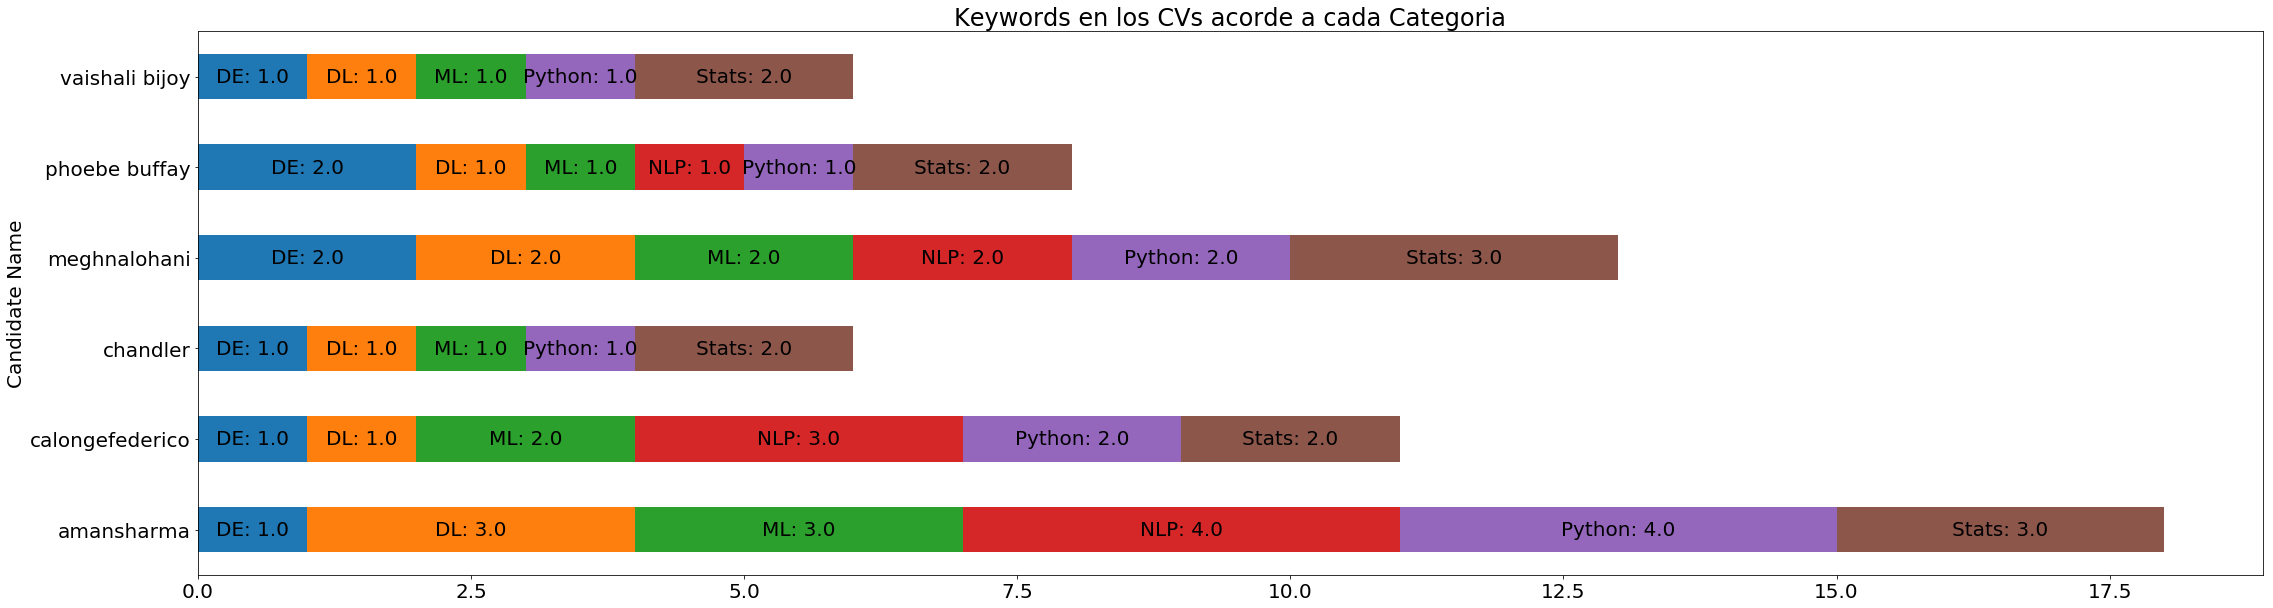

In [32]:
#Visualizamos el 'candidate profile' mediante un gráfico de barras usando los scores para cada skill.
#De esta manera el reclutador interpretará facilmente cada perfil de candidato. 

plt.rcParams.update({'font.size': 20})
ax = candidate_data.plot.barh(title="Keywords en los CVs acorde a cada Categoria", legend=False, figsize=(37,10), stacked=True)
skills = []
for j in candidate_data.columns:
    for i in candidate_data.index:
        skill = str(j)+": " + str(candidate_data.loc[i][j])
        skills.append(skill)
patches = ax.patches
for skill, rect in zip(skills, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., skill, ha='center', va='center')
plt.show()

In [1]:
#Conclusiones:
#De esta manera podemos machear cada skill en el cv del candidato con una keyword particular (machine learning, programming, etc.)
#basandonos en la distancia semantica entre las palabras (utilizando Word Embeddings). 
#El macheo lo realizamos con 'PhraseMatcher" de Spacy; y creamos un SCORE para cada keyword.
#Los SCORES finales los visualizamos en un bar plot.

#Mejoras:
#Tener un mejor CORPUS y mucho más grande que el skills.txt que tenemos (con vocabulario limitado) para que el modelo sea más preciso. 
#Agregar las palabras más comunes.

# Referencias

1. https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
2. https://www.shanelynn.ie/word-embeddings-in-python-with-spacy-and-gensim/
3. https://app.sketchengine.eu/
